# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy
import pickle
import shap
from sklearn.ensemble import RandomForestRegressor

/Users/yashv/Desktop/UPenn_Courses/Labs/CSS/team-process-map/team_process_map/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/yashv/Desktop/UPenn_Courses/Labs/CSS/team-process-map/team_process_map/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecat

# Dataset

In [2]:
csop_cols_to_ignore = [
    'conversation_num', 'batch_num', 'round_num', 'round_index',
    'task_index', 'complexity', 'type', 'social_perceptiveness', 
    'skill', 'speaker_nickname', 'message', 'normalized_score',
    'zscore_score', 'zscore_round_duration', 'zscore_efficiency',
    'message_lower_with_punc', 'dale_chall_classification'
]

In [3]:
csop_raw = pd.read_csv('../../output/csop_output_chat_level.csv')
csop_raw['timestamp'] = csop_raw.reset_index().groupby(by=['conversation_num'])['index'].rank(method='first').to_numpy()
csop = csop_raw.drop(csop_cols_to_ignore, axis=1)
# csop['target'] = StandardScaler().fit_transform(csop_raw['zscore_efficiency'].to_numpy().reshape(-1, 1))
csop['target'] = csop_raw['zscore_efficiency'].to_numpy()
csop.dropna(inplace=True)

In [4]:
X, y = csop.drop(['target'], axis=1), csop[['target']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_timestamps = X_train['timestamp'].to_numpy()
X_val_timestamps = X_val['timestamp'].to_numpy()
X_train.drop(['timestamp'], axis=1, inplace=True)
X_val.drop(['timestamp'], axis=1, inplace=True)


feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns)
X_val = pd.DataFrame(feature_scaler.transform(X_val.to_numpy()), columns=X_val.columns)

X_train['timestamp'] = X_train_timestamps
X_val['timestamp'] = X_val_timestamps

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3015, 97), (335, 97), (3015, 1), (335, 1))

In [17]:
# csop_raw = pd.read_csv('../../output/csop_output_chat_level.csv')
# csop_raw['timestamp'] = csop_raw.reset_index().groupby(by=['conversation_num'])['index'].rank(method='first').to_numpy()

# conversation_nums = sorted(list(csop_raw['conversation_num'].unique()))
# n_conversations = len(conversation_nums)
# train_conversations, val_conversations = conversation_nums[:int(n_conversations*0.9)], conversation_nums[int(n_conversations*0.9):]

# csop_raw['target'] = csop_raw['zscore_efficiency'].to_numpy()

# train_csop_raw = csop_raw[csop_raw['conversation_num'].isin(train_conversations)].copy()
# val_csop_raw = csop_raw[csop_raw['conversation_num'].isin(val_conversations)].copy()

# train_csop = train_csop_raw.drop(csop_cols_to_ignore, axis=1).dropna().sample(frac=1)
# val_csop = val_csop_raw.drop(csop_cols_to_ignore, axis=1).dropna().sample(frac=1)

# X_train, y_train = train_csop.drop(['target'], axis=1), train_csop['target']
# X_val, y_val = val_csop.drop(['target'], axis=1), val_csop['target']

# feature_scaler = StandardScaler()
# features_to_scale = [col for col in X_train.columns if col != 'timestamp']
# X_train[features_to_scale] = feature_scaler.fit_transform(X_train[features_to_scale])
# X_val[features_to_scale] = feature_scaler.transform(X_val[features_to_scale])
# X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2737, 97), (2737,), (613, 97), (613,))

# Helper Functions

In [5]:
def calc_metrics(y_true, y_pred):
    r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
    rmse = np.sqrt(mse).round(4)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)

    return {'r2': r2, 'mse': mse, 'mae': mae, 'rmse': rmse}

# Random Forests

In [14]:
rf = RandomForestRegressor(max_depth=7, max_features=0.2, random_state=42)
rf.fit(X_train, y_train.to_numpy().reshape((-1,)))

RandomForestRegressor(max_depth=7, max_features=0.2, random_state=42)

In [15]:
train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

In [16]:
# Train Metrics
calc_metrics(y_true=y_train, y_pred=train_preds)

{'r2': 0.3122, 'mse': 0.1933, 'mae': 0.314, 'rmse': 0.4397}

In [17]:
# Val Metrics
calc_metrics(y_true=y_val, y_pred=val_preds)

{'r2': 0.0906, 'mse': 0.2764, 'mae': 0.3576, 'rmse': 0.5257}

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


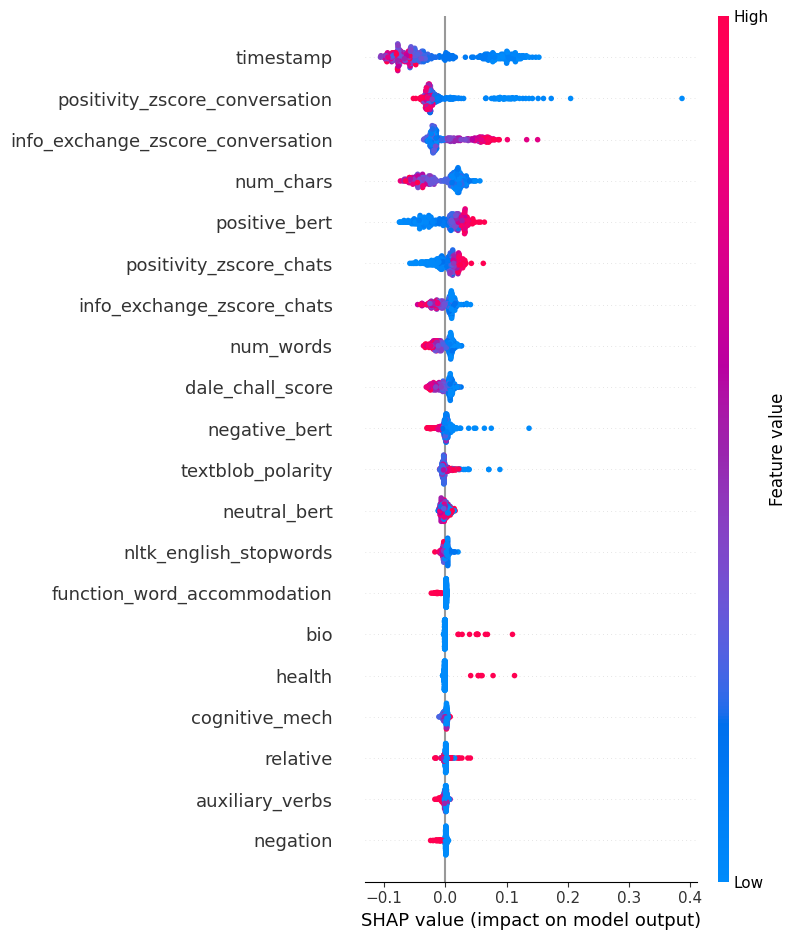

In [18]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, feature_names=X_train.columns)

# Artificial Neural Network

In [19]:
class CSOPDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [20]:
train_dataset = CSOPDataset(X=X_train.to_numpy(), y=y_train.to_numpy())
val_dataset = CSOPDataset(X=X_val.to_numpy(), y=y_val.to_numpy())

In [21]:
torch.manual_seed(42)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

In [22]:
class CSOPFullyConnectedNN(nn.Module):
    def __init__(self, num_input_features, num_hidden_layer_nodes=15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=num_hidden_layer_nodes),
            nn.ReLU(),
            nn.Linear(in_features=num_hidden_layer_nodes, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [23]:
def train(model, datasets, dataloaders, num_hidden_layer_neurons=15, learning_rate=0.00003, max_epochs=200):
    X_train, X_val, y_train, y_val = datasets
    train_dataloader, val_dataloader = dataloaders
    best_mse = float('inf')
    best_weights = None
    train_losses, val_losses = [], []

    loss_fn = nn.MSELoss()
    optimizer = Adam(params=model.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):
        # Training for one epoch
        model.train()
        train_loss = 0
        for (X_batch, y_batch) in train_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            train_loss += float(loss)
        # Calculating average training loss after one epoch
        avg_train_mse_loss = float(train_loss/len(train_dataloader))
        train_losses.append(avg_train_mse_loss)
        # writer.add_scalar('Training Loss', avg_train_mse_loss, epoch)
        # Validation after one epoch
        model.eval()
        val_loss = 0
        for X_batch, y_batch in val_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            val_mse_loss = loss_fn(y_pred, y_batch)
            val_loss += float(val_mse_loss)
        # Calculating average validation loss after one epoch
        avg_val_mse_loss = float(val_loss/len(val_dataloader))
        val_losses.append(avg_val_mse_loss)
        # writer.add_scalar('Validation Loss', avg_val_mse_loss, epoch)
        # Checking if we improved from the previous best epoch
        if avg_val_mse_loss < best_mse:
            best_mse = avg_val_mse_loss
            best_weights = copy.deepcopy(model.state_dict())
            best_epoch = epoch
    
    train_preds = model(torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
    val_preds = model(torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()
    train_metrics = calc_metrics(y_true=y_train, y_pred=train_preds)
    val_metrics = calc_metrics(y_true=y_val, y_pred=val_preds)
    

    model.load_state_dict(best_weights)
    model_cache = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': min(val_losses),
        'num_hidden_layer_neurons': num_hidden_layer_neurons,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
        'best_epoch': best_epoch,
        'train_r2': train_metrics['r2'],
        'train_mse': train_metrics['mse'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_mse': val_metrics['mse'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
    }
    return model_cache

In [27]:
model_cache = train(
    model=CSOPFullyConnectedNN(num_input_features=X_train.shape[1], num_hidden_layer_nodes=30), 
    datasets=(X_train, X_val, y_train, y_val), 
    dataloaders=(train_dataloader, val_dataloader), 
    num_hidden_layer_neurons=30, 
    learning_rate=0.00003, 
    max_epochs=1000
)
train_preds = model_cache['model'](torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = model_cache['model'](torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()
train_metrics = calc_metrics(y_true=y_train, y_pred=train_preds)
val_metrics = calc_metrics(y_true=y_val, y_pred=val_preds)

In [28]:
train_metrics

{'r2': 0.3093, 'mse': 0.1941, 'mae': 0.3121, 'rmse': 0.4406}

In [29]:
val_metrics

{'r2': 0.1269, 'mse': 0.2654, 'mae': 0.3614, 'rmse': 0.5152}

In [30]:
torch.save(model_cache['model'].state_dict(), 'feature_bagging_nn_models/fully_connected_nn_chat_level')

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


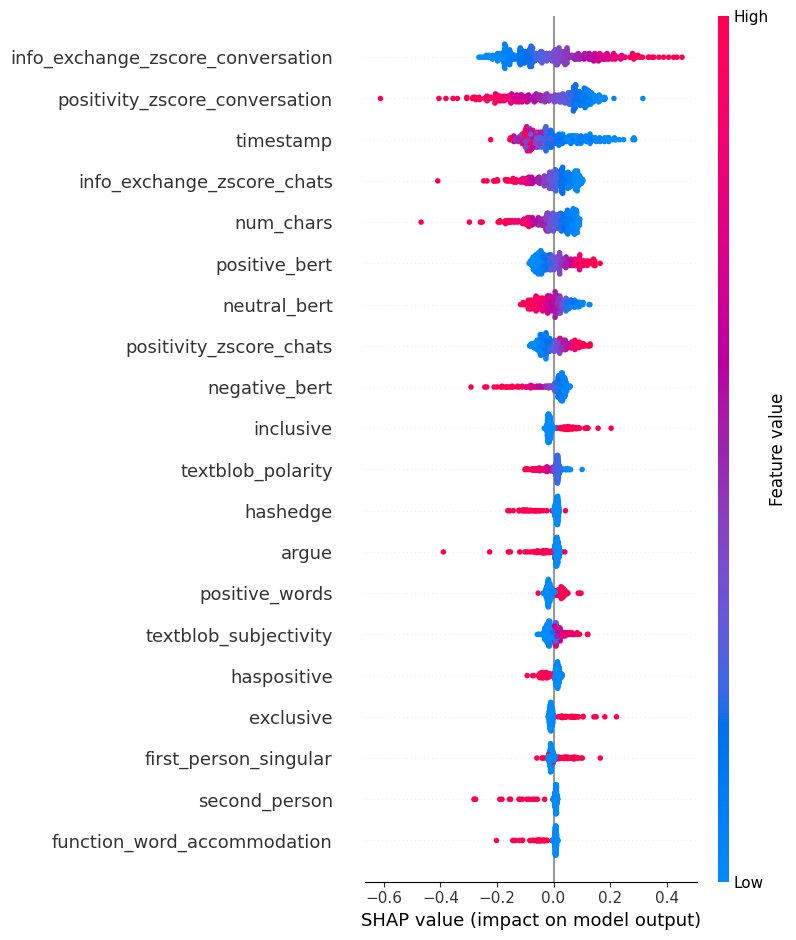

In [32]:
model = CSOPFullyConnectedNN(num_input_features=X_train.shape[1], num_hidden_layer_nodes=30)
model.load_state_dict(torch.load('feature_bagging_nn_models/fully_connected_nn_chat_level'))
explainer = shap.DeepExplainer(model, torch.tensor(X_train.to_numpy(), dtype=torch.float32))
shap_values = explainer.shap_values(torch.tensor(X_val.to_numpy(), dtype=torch.float32))
shap.summary_plot(shap_values, X_val, feature_names=X_train.columns)

# RNNs (Not working in Pytorch)

## Preparing Data Loaders

In [54]:
max_seq_length = csop_raw['conversation_num'].value_counts().sort_values(ascending=False).iloc[0]
rnn_csop_train, rnn_csop_train_targets, rnn_csop_val, rnn_csop_val_targets = [], [], [], []
for conv_no in train_conversations:
    train_seq = train_csop_raw[train_csop_raw['conversation_num'] == conv_no].drop(csop_cols_to_ignore, axis=1)
    rnn_csop_train_targets.append(train_seq['target'].to_list()[0])
    train_seq_padding = max_seq_length - train_seq.shape[0]
    rnn_csop_train.append(np.r_[train_seq.drop(['target'], axis=1).to_numpy(), np.zeros((train_seq_padding, train_seq.shape[1]-1))])

for conv_no in val_conversations:
    val_seq = val_csop_raw[val_csop_raw['conversation_num'] == conv_no].drop(csop_cols_to_ignore, axis=1)
    rnn_csop_val_targets.append(val_seq['target'].to_list()[0])
    val_seq_padding = max_seq_length - val_seq.shape[0]
    rnn_csop_val.append(np.r_[val_seq.drop(['target'], axis=1).to_numpy(), np.zeros((val_seq_padding, train_seq.shape[1]-1))])

rnn_csop_train, rnn_csop_train_targets, rnn_csop_val, rnn_csop_val_targets = np.array(rnn_csop_train), np.array(rnn_csop_train_targets), np.array(rnn_csop_val), np.array(rnn_csop_val_targets)
rnn_csop_train.shape, rnn_csop_train_targets.shape, rnn_csop_val.shape, rnn_csop_val_targets.shape

((882, 67, 97), (882,), (98, 67, 97), (98,))

In [71]:
rnn_X_train, rnn_y_train, rnn_X_val, rnn_y_val = rnn_csop_train, rnn_csop_train_targets, rnn_csop_val, rnn_csop_val_targets

In [72]:
class CSOPDatasetRNN(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx, :, :], self.y[idx]]

In [73]:
rnn_train_dataset = CSOPDatasetRNN(X=rnn_X_train, y=rnn_y_train)
rnn_val_dataset = CSOPDatasetRNN(X=rnn_X_val, y=rnn_y_val)

In [74]:
torch.manual_seed(42)
rnn_train_dataloader = DataLoader(dataset=rnn_train_dataset, batch_size=64, shuffle=True)
rnn_val_dataloader = DataLoader(dataset=rnn_val_dataset, batch_size=64, shuffle=True)

## Vanilla RNN

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [160]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, _ = self.rnn(x, h0)  
        out = torch.nan_to_num(out[:, -1, :], nan=0)
        out = self.fc(out)
        return out

In [161]:
rnn = RNN(input_size=rnn_X_train.shape[-1], hidden_size=rnn_X_train.shape[-1], num_layers=2).to(device)

In [162]:
def train_rnn(model, datasets, dataloaders, learning_rate=0.001, max_epochs=200):
    X_train, X_val, y_train, y_val = datasets
    train_dataloader, val_dataloader = dataloaders
    best_mse = float('inf')
    best_weights = None
    train_losses, val_losses = [], []

    loss_fn = nn.MSELoss()
    optimizer = Adam(params=model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(max_epochs), total=max_epochs):
        # Training for one epoch
        model.train()
        train_loss = 0
        for (X_batch, y_batch) in train_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            # print(X_batch.shape)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred.reshape((-1,)), y_batch.reshape((-1,)))
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            train_loss += float(loss)
        # Calculating average training loss after one epoch
        avg_train_mse_loss = float(train_loss/len(train_dataloader))
        train_losses.append(avg_train_mse_loss)
        # writer.add_scalar('Training Loss', avg_train_mse_loss, epoch)
        # Validation after one epoch
        model.eval()
        val_loss = 0
        for X_batch, y_batch in val_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            val_mse_loss = loss_fn(y_pred.reshape((-1,)), y_batch.reshape((-1,)))
            val_loss += float(val_mse_loss)
        # Calculating average validation loss after one epoch
        avg_val_mse_loss = float(val_loss/len(val_dataloader))
        val_losses.append(avg_val_mse_loss)
        # writer.add_scalar('Validation Loss', avg_val_mse_loss, epoch)
        # Checking if we improved from the previous best epoch
        if avg_val_mse_loss < best_mse:
            best_mse = avg_val_mse_loss
            best_weights = copy.deepcopy(model.state_dict())
            best_epoch = epoch
    
    train_preds = model(torch.tensor(X_train, dtype=torch.float32)).detach().numpy()
    val_preds = model(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
    train_metrics = calc_metrics(y_true=y_train, y_pred=train_preds)
    val_metrics = calc_metrics(y_true=y_val, y_pred=val_preds)

    model.load_state_dict(best_weights)
    model_cache = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': min(val_losses),
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
        'best_epoch': best_epoch,
        'train_r2': train_metrics['r2'],
        'train_mse': train_metrics['mse'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_mse': val_metrics['mse'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
    }
    return model_cache

In [163]:
rnn_model_cache = train_rnn(
    model=rnn, 
    datasets=(rnn_X_train, rnn_X_val, rnn_y_train, rnn_y_val), 
    dataloaders=(rnn_train_dataloader, rnn_val_dataloader), 
    learning_rate=0.00003, 
    max_epochs=100
)

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


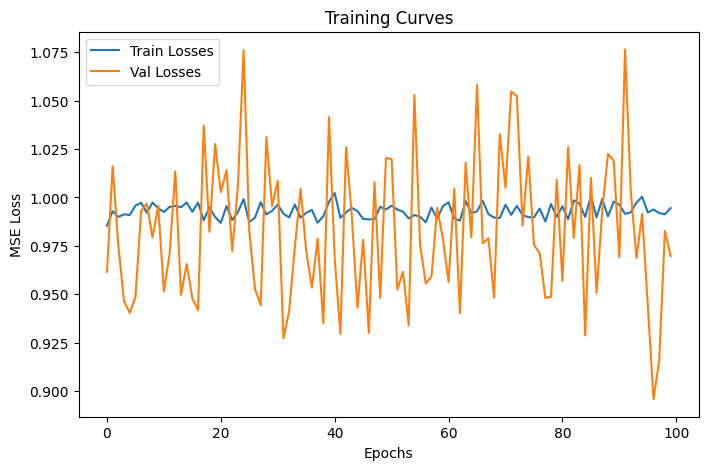

In [164]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rnn_model_cache['train_losses'], label='Train Losses')
ax.plot(rnn_model_cache['val_losses'], label='Val Losses')
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Training Curves')
ax.legend()
plt.show()

In [165]:
rnn_model_cache['train_r2'], rnn_model_cache['train_mse'], rnn_model_cache['train_rmse'], rnn_model_cache['train_mae']

(-0.0016, 0.9926, 0.9963, 0.7729)

In [166]:
rnn_model_cache['val_r2'], rnn_model_cache['val_mse'], rnn_model_cache['val_rmse'], rnn_model_cache['val_mae']

(-0.0793, 0.9829, 0.9914, 0.8474)

## LSTM

In [169]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, _ = self.lstm(x, (h0, c0))  
        # out = torch.nan_to_num(out[:, -1, :], nan=0)
        out = self.fc(out)
        return out

In [170]:
lstm = LSTM(input_size=rnn_X_train.shape[-1], hidden_size=rnn_X_train.shape[-1], num_layers=2).to(device)

In [171]:
f, t = next(iter(rnn_train_dataloader))

In [174]:
o = lstm(f.to(torch.float32))

In [178]:
f[1]

tensor([[0.2255, 0.0936, 0.6809,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [177]:
o[1, :, :]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

In [179]:
dummy_lstm = nn.LSTM(rnn_X_train.shape[-1], rnn_X_train.shape[-1], 2, batch_first=True)

In [182]:
o, h = dummy_lstm(f.to(torch.float32))

In [184]:
o.shape

torch.Size([64, 67, 97])

In [186]:
h

(tensor([[[-0.0192,  0.0511, -0.0134,  ...,  0.0438, -0.0492,  0.0085],
          [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
          [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
          ...,
          [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
          [-0.0192,  0.0511, -0.0134,  ...,  0.0438, -0.0492,  0.0085],
          [    nan,     nan,     nan,  ...,     nan,     nan,     nan]],
 
         [[-0.0136, -0.0162, -0.0552,  ...,  0.0671,  0.0217, -0.0159],
          [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
          [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
          ...,
          [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
          [-0.0136, -0.0162, -0.0552,  ...,  0.0671,  0.0217, -0.0159],
          [    nan,     nan,     nan,  ...,     nan,     nan,     nan]]],
        grad_fn=<StackBackward0>),
 tensor([[[-0.0392,  0.1090, -0.0257,  ...,  0.0884, -0.0996,  0.0

In [ ]:
lstm_model_cache = train_rnn(
    model=lstm, 
    datasets=(rnn_X_train, rnn_X_val, rnn_y_train, rnn_y_val), 
    dataloaders=(rnn_train_dataloader, rnn_val_dataloader), 
    learning_rate=0.00003, 
    max_epochs=100
)